Currently, to run this tutorial, from within a climada_python git repo please run:

```
mamba create -n climada_trajectory "python==3.11.*"
git fetch
git checkout feature/risk_trajectory
mamba env update -n climada_trajectory -f requirements/env_climada.yml
mamba activate climada_trajectory
python -m pip install -e ./

```

To be able to select that environment in jupyter you possibly might also need:

```
mamba install ipykernel
python -m ipykernel install --user --name climada_trajectory
```

# Important disclaimers

## Interpolation of risk can be... risky

The purpose of this module is to improve the evaluation of risk in between two "known" points in time.

It relies on interpolation (linear by default) of impacts and risk metrics in between the different points, 
which may lead to incoherent results in cases where this simplification drifts too far from reality.

As always users should carefully consider if the tool fits the purpose and if the limitations 
remain acceptable, even more so when used to design Disaster Risk Reduction or Climate Change Adaptation measures.

## Memory and computation requirements

This module adds a new dimension (time) to the risk, as such, it **multiplies** the memory and computation requirement along that dimension (although we avoid running a full-fledge impact computation for each "interpolated" point, we still have to define an impact matrix for each of those). 

This can of course (very) quickly increase the memory and computation requirements for bigger data. We encourage you to first try on small examples before running big computations.


# Using the `trajectories` module

The fundamental idea behing the `trajectories` module is to enable a better assessment of the evolution of risk over time.

Currently it proposes to look at the evolution between defined points in time and in the future we plan to also allow use a timeseries-oriented approach.

In this tutorial we present the current possibilities offered by the module.

## `Snapshot`: A snapshot of risk at a specific year

We use `Snapshot` objects to define a point in time. This object acts as a wrapper of the classic risk framework composed of Exposure, Hazard and Vulnerability. As such it is define for a specific year, and contains references to an `Exposures`, a `Hazard`, and an `ImpactFuncSet` object.

Next we show how to instantiate such a `Snapshot`. Note however that they are of little use by themselves, and what you will really use are `RiskTrajectory` which we present right after.

In [1]:
from climada.engine.impact_calc import ImpactCalc
from climada.util.api_client import Client
from climada.entity import ImpactFuncSet, ImpfTropCyclone
from climada.trajectories.snapshot import Snapshot

client = Client()

exp_present = client.get_litpop(country="Haiti")

haz_present = client.get_hazard(
    "tropical_cyclone",
    properties={
        "country_name": "Haiti",
        "climate_scenario": "historical",
        "nb_synth_tracks": "10",
    },
)
exp_present.assign_centroids(haz_present, distance="approx")

impf_set = ImpactFuncSet([ImpfTropCyclone.from_emanuel_usa()])
exp_present.gdf.rename(columns={"impf_": "impf_TC"}, inplace=True)
exp_present.gdf["impf_TC"] = 1
exp_present.gdf["group_id"] = (exp_present.gdf["value"] > 500000) * 1
snap = Snapshot(exp_present, haz_present, impf_set, 2018)

ERROR 1: PROJ: proj_create_from_database: Open of /home/sjuhel/miniforge3/envs/cb_refactoring/share/proj failed
/home/sjuhel/miniforge3/envs/cb_refactoring/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:15: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(


2025-05-21 16:01:03,369 - climada.entity.exposures.base - INFO - Reading /home/sjuhel/climada/data/exposures/litpop/LitPop_150arcsec_HTI/v3/LitPop_150arcsec_HTI.hdf5
2025-05-21 16:01:08,809 - climada.hazard.io - INFO - Reading /home/sjuhel/climada/data/hazard/tropical_cyclone/tropical_cyclone_10synth_tracks_150arcsec_HTI_1980_2020/v2/tropical_cyclone_10synth_tracks_150arcsec_HTI_1980_2020.hdf5
2025-05-21 16:01:08,836 - climada.entity.exposures.base - INFO - Matching 1329 exposures with 1332 centroids.
2025-05-21 16:01:08,838 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100


2025-05-21 15:55:57,839 - climada.util.coordinates - INFO - Raster from resolution 0.04166665999999708 to 0.04166665999999708.


<Axes: title={'center': 'TC 1: Emanuel 2011'}, xlabel='Intensity (m/s)', ylabel='Impact (%)'>

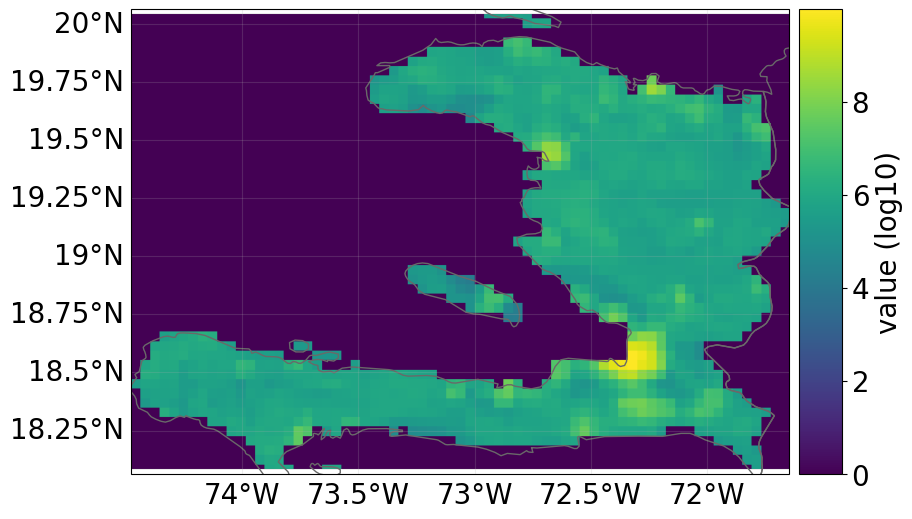

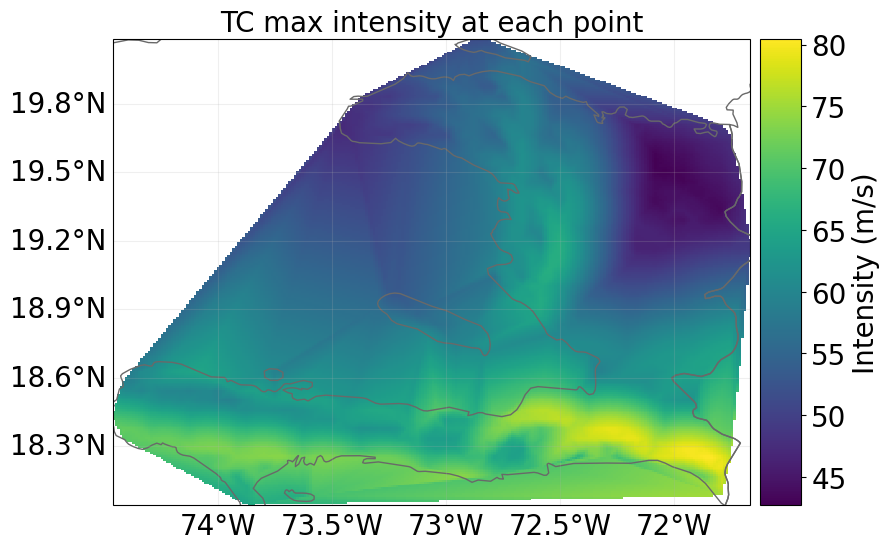

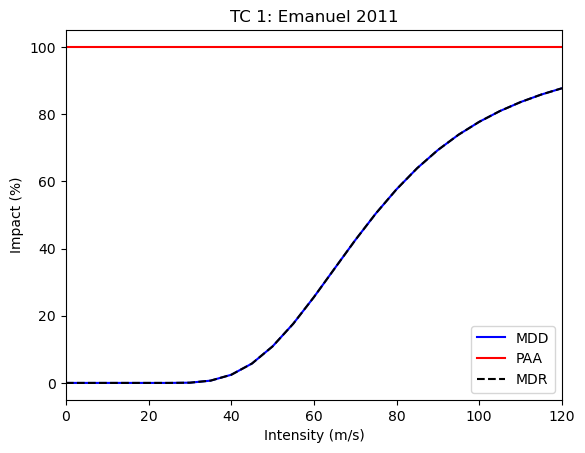

In [3]:
snap.exposure.plot_raster()
snap.hazard.plot_intensity(0)
snap.impfset.plot()

As stated previously, it makes little sense to define a Snapshot alone, so your main entry point should rather be the `RiskTrajectory` object.

`RiskTrajectory` uses one or more `RiskPeriod` under the hood, these objects used to hold pairs of `Snapshot` and compute the impacts at each dates in between.
This allows you to create a trajectory or risk with any number of snapshots.

So first, let us define a future point in time:

In [4]:
import copy

future_year = 2040
exp_future = copy.deepcopy(exp_present)
exp_future.ref_year = future_year
n_years = exp_future.ref_year - exp_present.ref_year + 1
growth_rate = 1.02
growth = growth_rate**n_years
exp_future.gdf["value"] = exp_future.gdf["value"] * growth

haz_future = client.get_hazard(
    "tropical_cyclone",
    properties={
        "country_name": "Haiti",
        "climate_scenario": "rcp60",
        "ref_year": str(future_year),
        "nb_synth_tracks": "10",
    },
)
exp_future.assign_centroids(haz_future, distance="approx")
impf_set = ImpactFuncSet(
    [
        ImpfTropCyclone.from_emanuel_usa(v_half=60.0),
    ]
)
exp_future.gdf.rename(columns={"impf_": "impf_TC"}, inplace=True)
exp_future.gdf["impf_TC"] = 1

2025-05-21 15:56:19,977 - climada.hazard.io - INFO - Reading /home/sjuhel/climada/data/hazard/tropical_cyclone/tropical_cyclone_10synth_tracks_150arcsec_rcp60_HTI_2040/v2/tropical_cyclone_10synth_tracks_150arcsec_rcp60_HTI_2040.hdf5
2025-05-21 15:56:20,006 - climada.entity.exposures.base - INFO - Exposures matching centroids already found for TC
2025-05-21 15:56:20,007 - climada.entity.exposures.base - INFO - Existing centroids will be overwritten for TC
2025-05-21 15:56:20,007 - climada.entity.exposures.base - INFO - Matching 1329 exposures with 1332 centroids.
2025-05-21 15:56:20,009 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100


<Axes: title={'center': 'TC 1: Emanuel 2011'}, xlabel='Intensity (m/s)', ylabel='Impact (%)'>

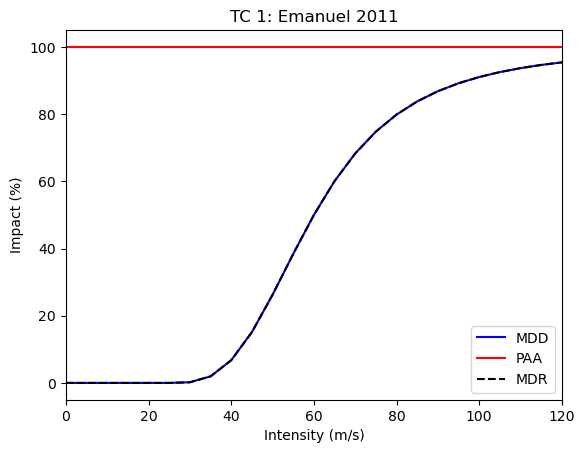

In [5]:
impf_set.plot()

In [6]:
snap2 = Snapshot(exp_future, haz_future, impf_set, 2040)

Now we can define a list of two snapshots, present and future:

In [7]:
snapcol = [snap, snap2]

Based on such a list of snapshots, you can then evaluate a risk trajectory using a `RiskTrajectory` object.

This object will hold risk metrics for all the dates between the different snapshots in the given collection for a given time frequency (a year by default)

In this example, from the snapshot in 2018 to the one in 2040. 

Note that this requires a bit of computation and memory, especially for large regions or extended range of time.

In [8]:
from climada.trajectories.risk_trajectory import RiskTrajectory

risk_traj = RiskTrajectory(snapcol)

2025-05-21 15:56:20,163 - climada.trajectories.riskperiod - INFO - Instantiating new CalcRiskPeriod.


From this object you can access different risk metrics:

* Average Annual Impact (aai)
* Estimated impact for different return periods (100, 500 and 1000 by default)

Both as totals over the whole period:

In [9]:
risk_traj.per_period_risk_metrics()

2025-05-21 15:56:20,172 - climada.trajectories.riskperiod - INFO - Instantiating new CalcRiskPeriod.
2025-05-21 15:56:20,175 - climada.entity.exposures.base - INFO - Exposures matching centroids already found for TC
2025-05-21 15:56:20,176 - climada.entity.exposures.base - INFO - Existing centroids will be overwritten for TC
2025-05-21 15:56:20,176 - climada.entity.exposures.base - INFO - Matching 1329 exposures with 1332 centroids.
2025-05-21 15:56:20,178 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2025-05-21 15:56:20,184 - climada.engine.impact_calc - INFO - Calculating impact for 3987 assets (>0) and 43560 events.
2025-05-21 15:56:20,194 - climada.entity.exposures.base - INFO - Exposures matching centroids already found for TC
2025-05-21 15:56:20,195 - climada.entity.exposures.base - INFO - Existing centroids will be overwritten for TC
2025-05-21 15:56:20,195 - climada.entity.exposure

,period,group,measure,metric,risk
0,2018-01-01 to 2040-01-01,0,no_measure,aai,1.487445e+07
1,2018-01-01 to 2040-01-01,1,no_measure,aai,9.945312e+09
2,2018-01-01 to 2040-01-01,All,no_measure,aai,9.960186e+09
3,2018-01-01 to 2040-01-01,All,no_measure,rp_100,3.288826e+11
4,2018-01-01 to 2040-01-01,All,no_measure,rp_50,1.886460e+11
5,2018-01-01 to 2040-01-01,All,no_measure,rp_500,8.369369e+11


Or on a per-date basis:

In [10]:
risk_traj.per_date_risk_metrics()

,date,group,measure,metric,risk
0,2018-01-01,All,no_measure,aai,1.840432e+08
1,2019-01-01,All,no_measure,aai,2.055335e+08
2,2020-01-01,All,no_measure,aai,2.271876e+08
3,2021-01-01,All,no_measure,aai,2.490056e+08
4,2022-01-01,All,no_measure,aai,2.709873e+08
...,...,...,...,...,...
41,2036-01-01,1,no_measure,aai,5.950431e+08
42,2037-01-01,1,no_measure,aai,6.194455e+08
43,2038-01-01,1,no_measure,aai,6.440116e+08
44,2039-01-01,1,no_measure,aai,6.687412e+08


You can also plot the "components" of the change in risk via a waterfall graph, both over the whole period:

<Axes: title={'center': 'Risk at 2018-01-01 and 2040-01-01 (Annual Average impact)'}, ylabel='USD'>

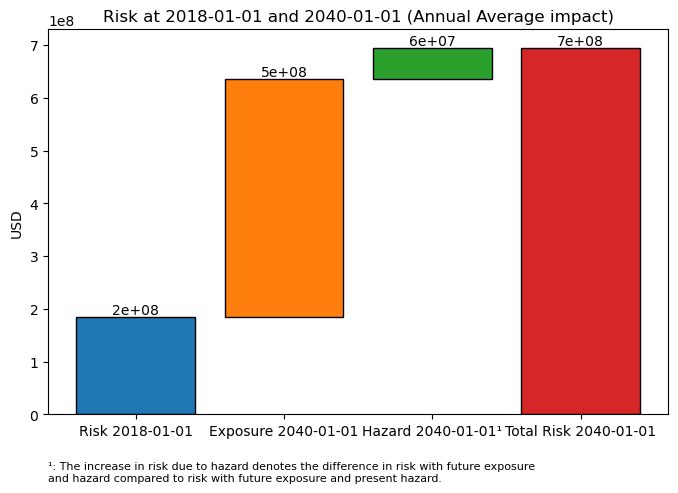

In [11]:
risk_traj.plot_waterfall()

And as well on a per date basis:

<Axes: title={'center': 'Risk between 2018-01-01 and 2040-01-01 (Annual Average impact)'}, xlabel='date', ylabel='USD'>

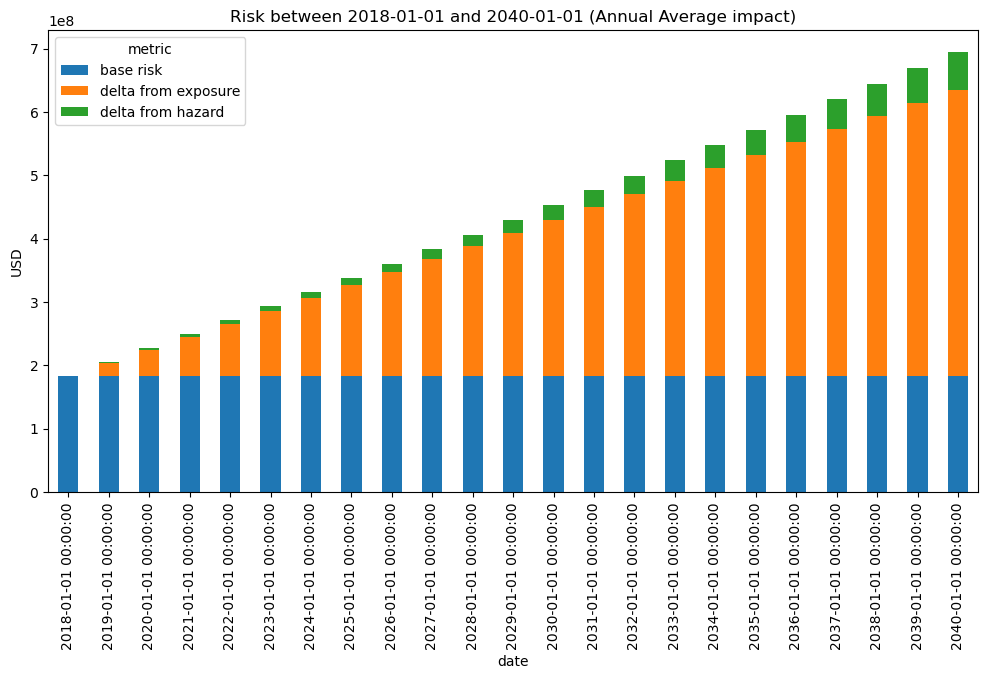

In [12]:
risk_traj.plot_per_date_waterfall()

Note that as warned in the first plot, we plot the change in risk due to exposure change only, and the additional change when considering change in hazard. As vulnerability is most often non-linear, this should be considered with caution.

### Grouping

This can be used for instance to evaluate how the risk for a specific type of asset, or a specific population, evolves in between two points in time.
Group are defined from the exposure data. Metric for each group are indexed by their corresponding ID (from the exposure) in the group column of the dataframes.

### DiscRates

To correctly assess the future risk, you may also want to apply a discount rate, in order to express future costs in net present value.

This can easily be done using the already existing `DiscRates` class:

In [13]:
from climada.entity import DiscRates
import numpy as np

year_range = np.arange(exp_present.ref_year, exp_future.ref_year + 1)
annual_discount_stern = np.ones(n_years) * 0.014
discount_stern = DiscRates(year_range, annual_discount_stern)

In [14]:
discounted_risk_traj = RiskTrajectory(snapcol, risk_disc=discount_stern)

2025-05-21 15:56:30,978 - climada.trajectories.riskperiod - INFO - Instantiating new CalcRiskPeriod.


In [15]:
discounted_risk_traj.per_date_risk_metrics()

2025-05-21 15:56:30,989 - climada.trajectories.riskperiod - INFO - Instantiating new CalcRiskPeriod.
2025-05-21 15:56:30,992 - climada.entity.exposures.base - INFO - Exposures matching centroids already found for TC
2025-05-21 15:56:30,992 - climada.entity.exposures.base - INFO - Existing centroids will be overwritten for TC
2025-05-21 15:56:30,992 - climada.entity.exposures.base - INFO - Matching 1329 exposures with 1332 centroids.
2025-05-21 15:56:30,994 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2025-05-21 15:56:30,998 - climada.engine.impact_calc - INFO - Calculating impact for 3987 assets (>0) and 43560 events.
2025-05-21 15:56:31,009 - climada.entity.exposures.base - INFO - Exposures matching centroids already found for TC
2025-05-21 15:56:31,009 - climada.entity.exposures.base - INFO - Existing centroids will be overwritten for TC
2025-05-21 15:56:31,010 - climada.entity.exposure

,date,group,measure,metric,risk
0,2018-01-01,All,no_measure,aai,1.840432e+08
1,2019-01-01,All,no_measure,aai,2.026958e+08
2,2020-01-01,All,no_measure,aai,2.209575e+08
3,2021-01-01,All,no_measure,aai,2.388335e+08
4,2022-01-01,All,no_measure,aai,2.563287e+08
...,...,...,...,...,...
41,2036-01-01,1,no_measure,aai,4.633031e+08
42,2037-01-01,1,no_measure,aai,4.756440e+08
43,2038-01-01,1,no_measure,aai,4.876796e+08
44,2039-01-01,1,no_measure,aai,4.994144e+08


In [16]:
discounted_risk_traj.per_date_risk_metrics().loc[
    discounted_risk_traj.per_date_risk_metrics()["metric"] == "aai"
]

,date,group,measure,metric,risk
0,2018-01-01,All,no_measure,aai,1.840432e+08
1,2019-01-01,All,no_measure,aai,2.026958e+08
2,2020-01-01,All,no_measure,aai,2.209575e+08
3,2021-01-01,All,no_measure,aai,2.388335e+08
4,2022-01-01,All,no_measure,aai,2.563287e+08
...,...,...,...,...,...
41,2036-01-01,1,no_measure,aai,4.633031e+08
42,2037-01-01,1,no_measure,aai,4.756440e+08
43,2038-01-01,1,no_measure,aai,4.876796e+08
44,2039-01-01,1,no_measure,aai,4.994144e+08


<Axes: xlabel='date', ylabel='risk'>

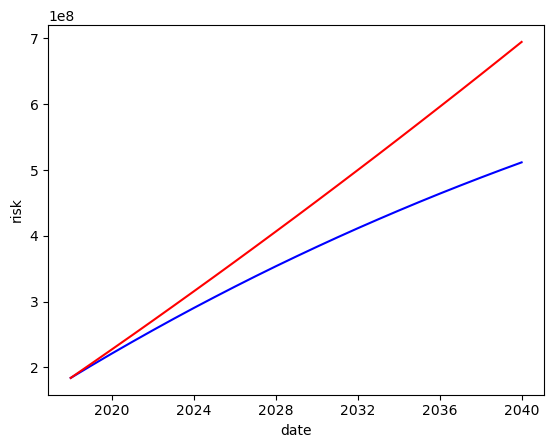

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

g = sns.lineplot(
    discounted_risk_traj.per_date_risk_metrics().loc[
        (discounted_risk_traj.per_date_risk_metrics()["metric"] == "aai")
        & (discounted_risk_traj.per_date_risk_metrics()["group"] == "All")
    ],
    x="date",
    y="risk",
    color="blue",
)
sns.lineplot(
    risk_traj.per_date_risk_metrics().loc[
        (risk_traj.per_date_risk_metrics()["metric"] == "aai")
        & (risk_traj.per_date_risk_metrics()["group"] == "All")
    ],
    x="date",
    y="risk",
    ax=g,
    color="red",
)

# Advanced usage

In this section we present some more advanced feature and usage of this module.

## Higher number of snapshots

In [3]:
from climada.engine.impact_calc import ImpactCalc
from climada.util.api_client import Client
from climada.entity import ImpactFuncSet, ImpfTropCyclone
from climada.trajectories.snapshot import Snapshot
from climada.trajectories.risk_trajectory import RiskTrajectory
import copy

client = Client()


future_years = [2040, 2060, 2080]

exp_present = client.get_litpop(country="Haiti")
haz_present = client.get_hazard(
    "tropical_cyclone",
    properties={
        "country_name": "Haiti",
        "climate_scenario": "historical",
        "nb_synth_tracks": "10",
    },
)
exp_present.assign_centroids(haz_present, distance="approx")

impf_set = ImpactFuncSet([ImpfTropCyclone.from_emanuel_usa()])
exp_present.gdf.rename(columns={"impf_": "impf_TC"}, inplace=True)
exp_present.gdf["impf_TC"] = 1
exp_present.gdf["group_id"] = (exp_present.gdf["value"] > 500000) * 1

snapcol = [Snapshot(exp_present, haz_present, impf_set, 2018)]

for year in future_years:
    exp_future = copy.deepcopy(exp_present)
    exp_future.ref_year = year
    n_years = exp_future.ref_year - exp_present.ref_year + 1
    growth_rate = 1.02
    growth = growth_rate**n_years
    exp_future.gdf["value"] = exp_future.gdf["value"] * growth

    haz_future = client.get_hazard(
        "tropical_cyclone",
        properties={
            "country_name": "Haiti",
            "climate_scenario": "rcp60",
            "ref_year": str(year),
            "nb_synth_tracks": "10",
        },
    )
    exp_future.assign_centroids(haz_future, distance="approx")
    impf_set = ImpactFuncSet(
        [
            ImpfTropCyclone.from_emanuel_usa(v_half=60.0),
        ]
    )
    exp_future.gdf.rename(columns={"impf_": "impf_TC"}, inplace=True)
    exp_future.gdf["impf_TC"] = 1
    snapcol.append(Snapshot(exp_future, haz_future, impf_set, year))

2025-05-21 16:01:50,165 - climada.entity.exposures.base - INFO - Reading /home/sjuhel/climada/data/exposures/litpop/LitPop_150arcsec_HTI/v3/LitPop_150arcsec_HTI.hdf5
2025-05-21 16:01:55,538 - climada.hazard.io - INFO - Reading /home/sjuhel/climada/data/hazard/tropical_cyclone/tropical_cyclone_10synth_tracks_150arcsec_HTI_1980_2020/v2/tropical_cyclone_10synth_tracks_150arcsec_HTI_1980_2020.hdf5
2025-05-21 16:01:55,569 - climada.entity.exposures.base - INFO - Matching 1329 exposures with 1332 centroids.
2025-05-21 16:01:55,571 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2025-05-21 16:02:00,968 - climada.hazard.io - INFO - Reading /home/sjuhel/climada/data/hazard/tropical_cyclone/tropical_cyclone_10synth_tracks_150arcsec_rcp60_HTI_2040/v2/tropical_cyclone_10synth_tracks_150arcsec_rcp60_HTI_2040.hdf5
2025-05-21 16:02:01,000 - climada.entity.exposures.base - INFO - Exposures matching centroid

In [4]:
risk_traj = RiskTrajectory(snapcol)

2025-05-21 16:02:48,338 - climada.trajectories.riskperiod - INFO - Instantiating new CalcRiskPeriod.
2025-05-21 16:02:48,340 - climada.trajectories.riskperiod - INFO - Instantiating new CalcRiskPeriod.
2025-05-21 16:02:48,341 - climada.trajectories.riskperiod - INFO - Instantiating new CalcRiskPeriod.


In [5]:
risk_traj.aai_metrics()

2025-05-21 16:02:50,423 - climada.trajectories.riskperiod - INFO - Instantiating new CalcRiskPeriod.
2025-05-21 16:02:50,425 - climada.trajectories.riskperiod - INFO - Instantiating new CalcRiskPeriod.
2025-05-21 16:02:50,426 - climada.trajectories.riskperiod - INFO - Instantiating new CalcRiskPeriod.
2025-05-21 16:02:50,428 - climada.entity.exposures.base - INFO - Exposures matching centroids already found for TC
2025-05-21 16:02:50,429 - climada.entity.exposures.base - INFO - Existing centroids will be overwritten for TC
2025-05-21 16:02:50,429 - climada.entity.exposures.base - INFO - Matching 1329 exposures with 1332 centroids.
2025-05-21 16:02:50,431 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2025-05-21 16:02:50,435 - climada.engine.impact_calc - INFO - Calculating impact for 3987 assets (>0) and 43560 events.
2025-05-21 16:02:50,445 - climada.entity.exposures.base - INFO - Exposure

,date,group,measure,metric,risk
0,2018-01-01,All,no_measure,aai,1.840432e+08
1,2019-01-01,All,no_measure,aai,2.055335e+08
2,2020-01-01,All,no_measure,aai,2.271876e+08
3,2021-01-01,All,no_measure,aai,2.490056e+08
4,2022-01-01,All,no_measure,aai,2.709873e+08
...,...,...,...,...,...
58,2076-01-01,All,no_measure,aai,1.641765e+09
59,2077-01-01,All,no_measure,aai,1.677493e+09
60,2078-01-01,All,no_measure,aai,1.713461e+09
61,2079-01-01,All,no_measure,aai,1.749670e+09


<Axes: title={'center': 'Risk between 2018-01-01 and 2080-01-01 (Annual Average impact)'}, xlabel='date', ylabel='USD'>

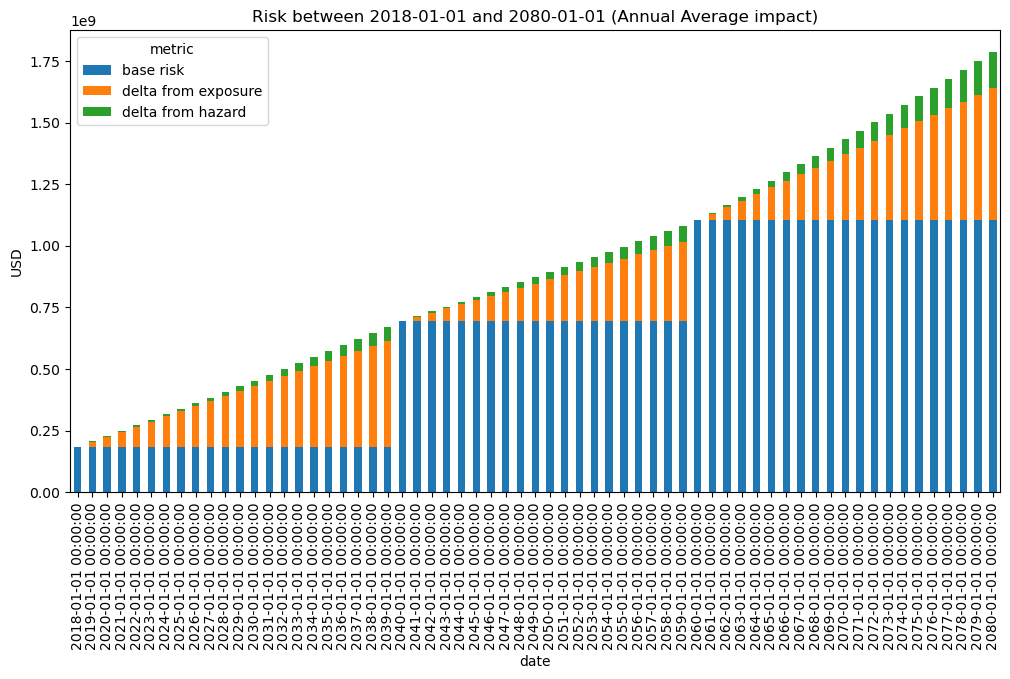

In [6]:
risk_traj.plot_per_date_waterfall()

## Non-yearly date index

## Non-linear interpolation

## Spatial mapping

## "Big" data